In [1]:
!pip3 install git+https://github.com/holounic/Bayesian-Optimization.git
!pip3 install cma

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/holounic/Bayesian-Optimization.git to /tmp/pip-req-build-2kqoqsw5
  Running command git clone -q https://github.com/holounic/Bayesian-Optimization.git /tmp/pip-req-build-2kqoqsw5
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Cloning https://github.com/holounic/pyDOE to /tmp/pip-install-5jf1wzmw/pydoe_8b25b937e3034eb4ac9ca3c9b130c52a
  Running command git clone -q https://github.com/holounic/pyDOE /tmp/pip-install-5jf1wzmw/pydoe_8b25b937e3034eb4ac9ca3c9b130c52a
     |████████████████████████████████| 62 kB 1.5 MB/s 
     |████████████████████████████████| 316 kB 40.8 MB/s 
  Created wheel for bayes-optim: filename=bayes_optim-0.2.7-py3-none-any.whl size=145057 sha256=46f483ffbf5dcdaa3e3f61ca81a25b1ba6a1b75c763f5a60efda9cb81c993b7d
  Stored in directory: /tmp/pip-ephem-wheel-cache-

In [2]:
import pandas as pd

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import cma

from pyDOE import lhs

from bayes_optim import BO
from bayes_optim.search_space import RealSpace
from bayes_optim.surrogate import GaussianProcess, trend

from benchmark.bbobbenchmarks import F12

from tqdm.notebook import trange

np.random.seed(1111)

dim = 2
lb, ub = -5, 5

mean = trend.constant_trend(dim, beta=None)
thetaL = 1e-10 * (ub - lb) * np.ones(dim)
thetaU = 10 * (ub - lb) * np.ones(dim)
theta0 = np.random.rand(dim) * (thetaU - thetaL) + thetaL

max_FEs = 2**6
verbose = False

n_samples = 30000

max_cma_iter = 20

In [4]:
opt_color, found_color, initial_color = "green", "red", "blue"

def plot(points, colors, ax=plt, outline=False, marker='o', marker_size=30):
    transposed = np.transpose(points)
    if outline:
        ax.scatter(transposed[0], transposed[1], color="none", edgecolor=colors, marker=marker, s=marker_size)
    else:
        ax.scatter(transposed[0], transposed[1], c=colors, marker=marker, s=marker_size)


# plot DoE, optimum, found by the BO, and global optimum on the surface of the function
def plot_result(func, samples, values, result, ax):
  plot(samples, values, ax=ax, outline=False)
  if result["initial_points"] is not None:
    plot(result["initial_points"], ["blue"] * result["initial_points"].shape[0], ax=ax, marker='^')
  ax.set_title(f'{result.get("description", "regret")}: {result["regret"]}', size=6)
  plot([func._getxopt(), result["found_x"]], [opt_color, found_color], ax=ax, marker='s')


# plot initial points provided to the CMA-ES and DoE, found by it, on the surface of the function
def plot_initial_found(func, samples, values, initial, found, result):
  fig, axs = plt.subplots(1, 2)
  fig.suptitle("Objective function " + func.__class__.__name__, fontsize=8)
  plot(samples, values, ax=axs[0], outline=False) # plot surface
  axs[0].set_title('Initial individual for CMA-ES')
  plot(samples, values, ax=axs[1], outline=False)
  axs[1].set_title('DoE found by CMA-ES')
  plot(initial, ["blue"] * initial.shape[0], ax=axs[0], outline=False)
  plot(found, ["yellow"] * initial.shape[0], ax=axs[1], outline=False)
  plt.show()


# plot DoE, all points used by the BO during training, global optimum, found optimum
def plot_ei_performance(func, samples, values, bo, result, marker_size=30, ax=None):
  if ax is None:
    ax = plt.gca()
  plot(samples, values, ax=ax, outline=False) # plot surface
  if result["doe"] is not None:
    plot(result["doe"], ["blue"] * result["doe"].shape[0], ax=ax, marker='^', marker_size=marker_size*2)
  
  for i in range(1, len(bo.history)):
    for h in bo.history[i]:
      x, y = h
      ax.scatter(x, y, color="magenta", s=marker_size)
      ax.annotate(str(i), h)
  plot([func._getxopt(), result["xopt"]], [opt_color, found_color], ax=ax, marker='s', marker_size=marker_size)

def plot_mult_performance(samples, results, marker_size=30):
    _, axs = plt.subplots(2, 2)
    for (ax, result) in zip(axs.flatten(), results):
      ax.title.set_text(result['title'])
      func = F12(result['f_s'])
      values = func(samples)
      plot_ei_performance(func, samples, values, result['bo'], result, marker_size=30, ax=ax)

In [5]:
def make_optimizer(obj_func, doe):
    space = RealSpace([lb, ub], random_state=np.random.randint(1, 10000)) * dim
    model = GaussianProcess(
        mean=mean,
        corr="squared_exponential",
        theta0=theta0,
        thetaL=thetaL,
        thetaU=thetaU,
        nugget=0,
        noise_estim=False,
        optimizer="BFGS",
        wait_iter=3,
        random_start=dim,
        likelihood="concentrated",
        eval_budget=100 * dim
    )
    return BO(
        search_space=space,
        obj_fun=obj_func,
        model=model,
        DoE_size=len(doe),
        acquisition_fun="EI",
        initial_points=doe,
        max_FEs=max_FEs,
        verbose=verbose,
        n_point=1
    )

def compute_regret(doe, n=3):
  regrets = []
  best_bo, worst_bo = None, None
  for _ in range(n):
    obj_func = F12(np.random.randint(0, 2**31))
    bo = make_optimizer(obj_func, doe)
    xopt, yopt, _ = bo.run()
    cur_regret = yopt - obj_func.getfopt()
    regrets.append(cur_regret)
    if cur_regret <= min(regrets):
      best_bo = (bo, xopt, yopt, cur_regret)
    if cur_regret >= max(regrets):
      worst_bo = (bo, xopt, yopt, cur_regret)
  return np.concatenate(regrets).mean(), best_bo, worst_bo

def compute_regret_fixed(obj_func, doe, n=3):
  regrets = []
  best_bo, worst_bo = None, None
  for _ in range(n):
    bo = make_optimizer(obj_func, doe)
    xopt, yopt, _ = bo.run()
    cur_regret = yopt - obj_func.getfopt()
    regrets.append(cur_regret)
    if cur_regret <= min(regrets):
      best_bo = (bo, xopt, yopt, cur_regret)
    if cur_regret >= max(regrets):
      worst_bo = (bo, xopt, yopt, cur_regret)
  return np.concatenate(regrets).mean(), best_bo, worst_bo
 
def regret_function(doe_size, n=3):
    def func(X):
        X = X.clip(lb, ub, out=X)
        doe = np.split(X, doe_size)
        regret, _, _ = compute_regret(doe, n)
        return regret
    return func

In [6]:
def best_and_worst(history):
  def upd_min(t, c, f):
    if t is None:
      return c
    if t[f] > c[f]:
      return c
    return t
  def upd_max(t, c, f):
    if t is None:
      return c
    if t[f] < c[f]:
      return c
    return t
  best_regret, worst_regret = None, None
  best_precision, worst_precision = None, None
  for h in history:
    best_regret = upd_min(best_regret, h, 'regret')
    worst_regret = upd_max(worst_regret, h, 'regret')
    best_precision = upd_min(best_precision, h, 'precision')
    worst_precision = upd_max(worst_precision, h, 'precision')
  best_regret['title'] = 'min regret'
  worst_regret['title'] = 'max regret'
  best_precision['title'] = 'min precision'
  worst_precision['title'] = 'max precision'
  return best_regret, worst_regret, best_precision, worst_precision

In [7]:
def compute_all(r, doe, n=3, n_points=1000):
  regrets = []
  history = []
  precisions = []
  for seed in trange(n):
    func_seed = r.randint(0, 2**31)
    obj_func = F12(func_seed)
    bo = make_optimizer(obj_func, doe)
    xopt, yopt, _ = bo.run()
    regret = yopt - obj_func.getfopt()
    points = lhs(dim, n_points) * 10 - 5
    predicted_y = np.concatenate(bo.model.predict(points))
    real_y = obj_func(points)
    precision = np.mean((predicted_y - real_y)**2)
    precisions.append(precision)
    regrets.append(regret)
    history.append({'xopt': xopt, 'yopt': yopt, 'regret': regret, 'doe': doe, 'precision': precision, 'bo': bo, 'f_s': func_seed})
  return np.concatenate(regrets).mean(), np.mean(precisions), history

In [8]:
def additional_metrics(history):
  for h in history:
    f = F12(h['f_s'])
    y = f(h['xopt'])
    real_x = f._getxopt()
    d = np.linalg.norm(h['doe'] - real_x, axis=1)
    h['min_dist_to_opt'] = d.min()
    h['maxx_dist_to_opt'] = d.max()
    h['real_xopt'] = real_x
    h['real_yopt'] = f.getfopt()
    h['bo_history'] = h['bo'].history
  return history

def not_obvious(thr_d, thr_r):
  def func(h):
    f = F12(h['f_s'])
    y = f(h['xopt'])
    real_x = f._getxopt()
    return np.linalg.norm(h['doe'] - real_x, axis=1).min() > thr_d and h['regret'] < thr_r
  return func

def collect_by_criterion(history, criterion):
  good = []
  for h in history:
    if not criterion(h):
      continue
    good.append(h)
  return good

## Experiments

In [9]:
def cma_es_experiment(doe_size, n_test=10, individual0=None, sigma0 = ub / 3):
  if individual0 is None:
    individual0 = np.zeros(doe_size * dim) # initial individual
  
  # regret function with fixed random
  regret_func = regret_function(doe_size, n=n_test)
  # run cma-es 
  doe_flattened, es = cma.fmin2(regret_func, individual0, sigma0, {'maxiter': max_cma_iter})
  
  # split a vector into set of points
  doe = np.split(doe_flattened, doe_size)

  return doe, es

## DoE of size [0.1 * 2**6] = 6

In [21]:
samples = (RealSpace([lb, ub]) * dim).sample(n_samples)

In [10]:
doe_budget = 0.1
doe_size = int(doe_budget * max_FEs)

In [13]:
individual0 = np.concatenate(lhs(2, doe_size) * 10 - 5)

In [15]:
individual0

array([-3.5884873 , -0.27239499, -3.12231728,  4.10788457,  0.3201013 ,
       -4.58203186, -0.8201856 ,  2.21840321,  2.85376454, -1.78871035,
        3.98735493,  1.46955875])

### sigma = 3.5

In [ ]:
doe35, es35 = cma_es_experiment(doe_size, individual0=individual0, sigma0=3.5, n_test=3)

(5_w,11)-aCMA-ES (mu_w=3.4,w_1=42%) in dimension 12 (seed=711401, Fri Nov  4 14:24:06 2022)
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelih

In [ ]:
doe35

[array([-0.2569646,  1.9597943]),
 array([-4.84804191, -3.95480122]),
 array([ 3.11399094, -1.83930904]),
 array([-2.57209832,  0.7681288 ]),
 array([-1.07591418,  3.22290607]),
 array([ 3.77000795, -5.        ])]

#### CMA-ES generated

In [31]:
precision, regret, history = compute_all(np.random.RandomState(1), np.array(doe35), n=100, n_points=10000)

  0%|          | 0/100 [00:00<?, ?it/s]

Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likel

In [32]:
regret

3.2689802343553212e+19

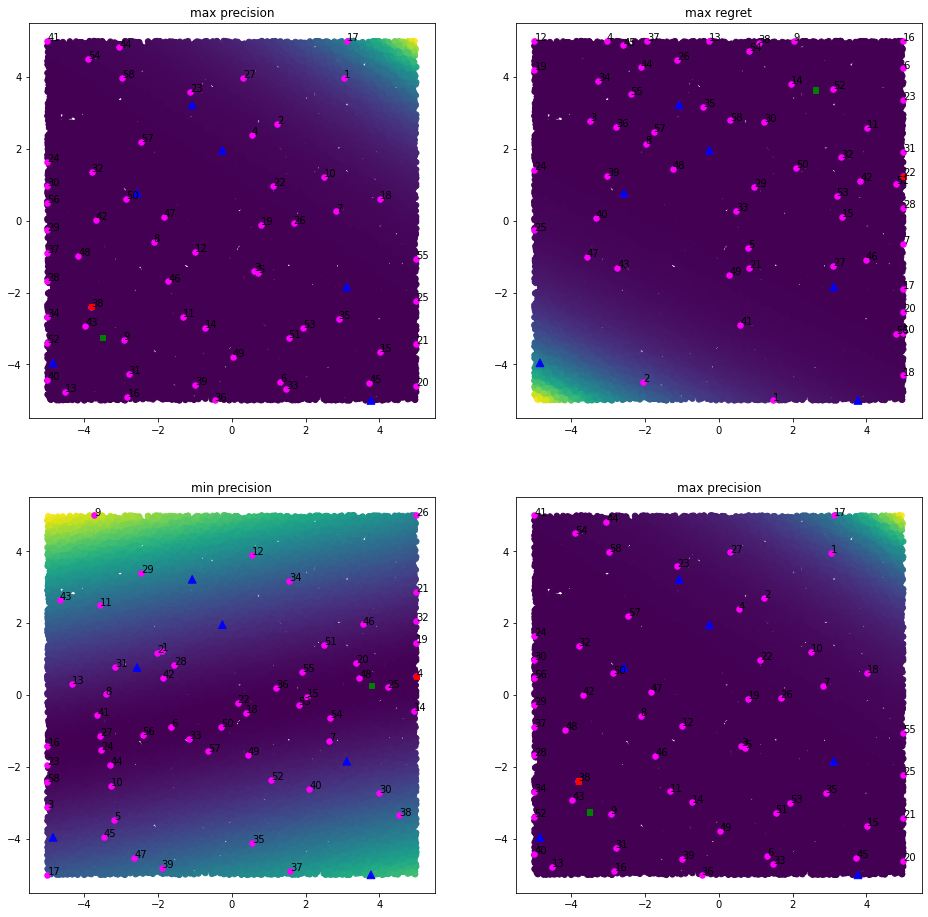

In [67]:
plt.rcParams["figure.figsize"] = (16, 16)
best_regret, worst_regret, best_precision, worst_precision = best_and_worst(history)
plot_mult_performance(samples, (best_regret, worst_regret, best_precision, worst_precision), marker_size=30)

In [35]:
best_precision['precision'], best_precision['regret'], best_precision['f_s']

(146437371919263.34, array([152.75864441]), 1487394068)

In [36]:
best_regret['precision'], best_regret['regret'], best_precision['f_s']

(1.1155315885852966e+21, array([4.1078883]), 1487394068)

In [37]:
doe35

[array([-0.2569646,  1.9597943]),
 array([-4.84804191, -3.95480122]),
 array([ 3.11399094, -1.83930904]),
 array([-2.57209832,  0.7681288 ]),
 array([-1.07591418,  3.22290607]),
 array([ 3.77000795, -5.        ])]

In [74]:
good_35 = collect_by_criterion(history, not_obvious(2.8, 100))
len(good_35)

4

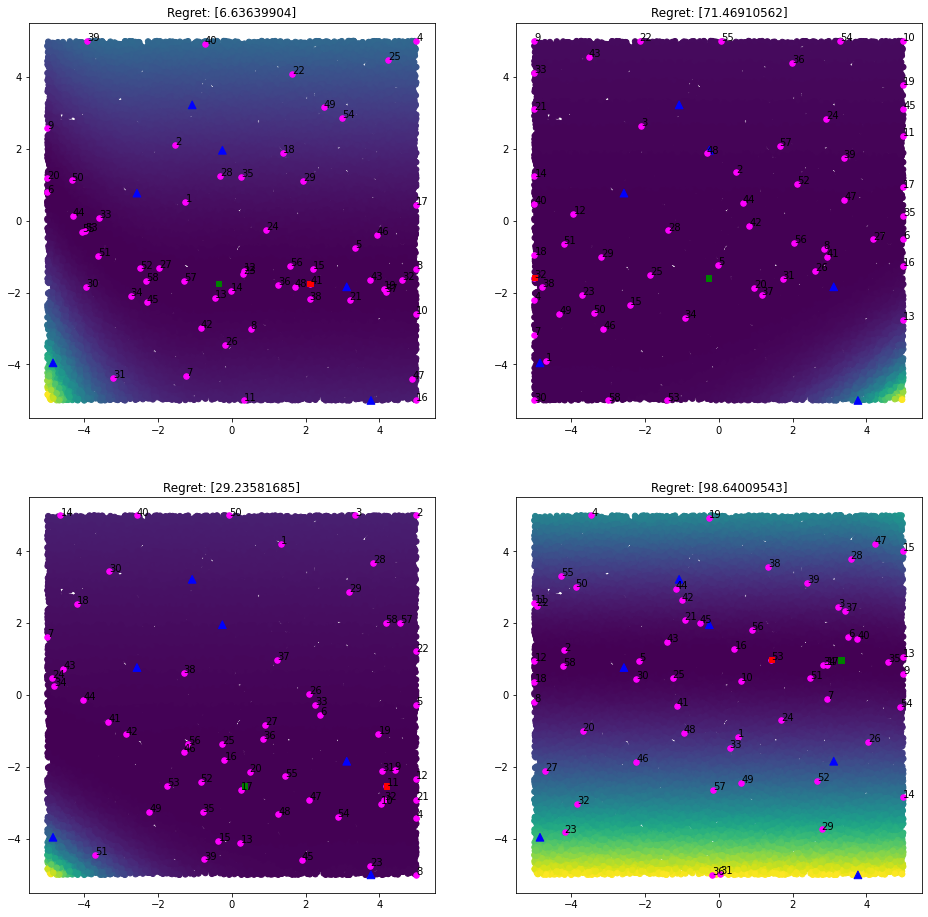

In [75]:
plt.rcParams["figure.figsize"] = (16, 16)
for h in good_35:
  h['title'] = 'Regret: ' + str(h['regret'])
plot_mult_performance(samples, good_35, marker_size=30)

In [76]:
df_35 = pd.DataFrame(additional_metrics(history)).drop(['title', 'bo'], axis=1)
df_35.to_csv('doe_35.csv')

#### DoE used to initialize CMA-ES

In [38]:
doe_lhs = np.split(individual0, doe_size)
lhs_precision, lhs_regret, lhs_history = compute_all(np.random.RandomState(1), np.array(doe_lhs), n=100, n_points=10000)

  0%|          | 0/100 [00:00<?, ?it/s]

Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likel

In [39]:
lhs_regret

3.3806443476587827e+19

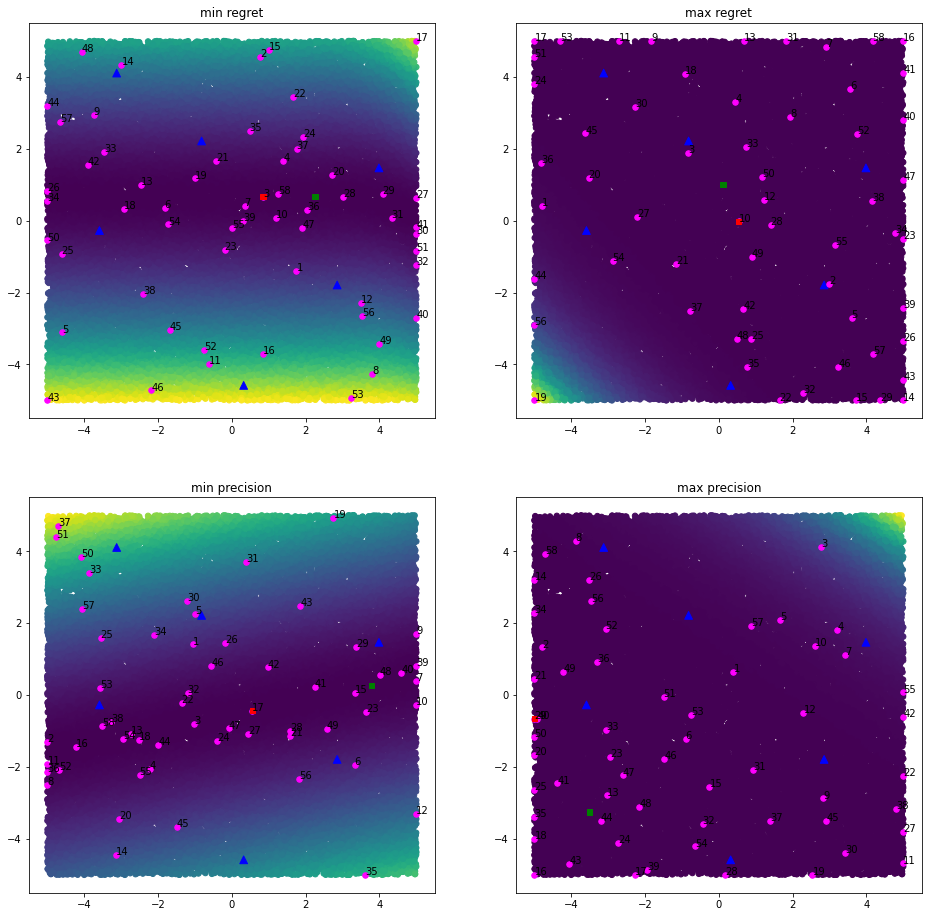

In [66]:
plt.rcParams["figure.figsize"] = (16, 16)
lhs_best_regret, lhs_worst_regret, lhs_best_precision, lhs_worst_precision = best_and_worst(lhs_history)
plot_mult_performance(samples, (lhs_best_regret, lhs_worst_regret, lhs_best_precision, lhs_worst_precision), marker_size=30)

In [42]:
lhs_best_precision['precision'], lhs_best_precision['regret'], lhs_best_precision['f_s']

(145808584138493.8, array([174.79759006]), 1487394068)

In [43]:
lhs_best_regret['precision'], lhs_best_regret['regret'], lhs_best_precision['f_s']

(150891725603660.84, array([2.06133214]), 1487394068)

In [82]:
good_lhs = collect_by_criterion(lhs_history, not_obvious(2.2, 100))
len(good_lhs)

4

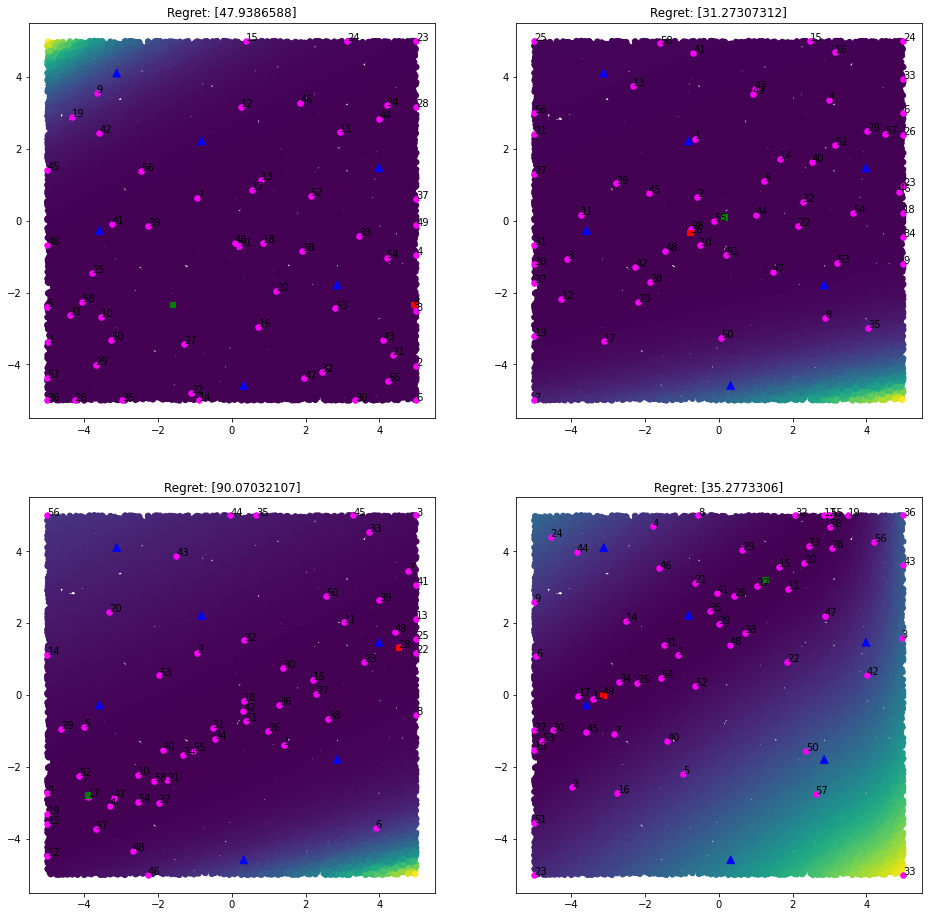

In [83]:
for h in good_lhs:
  h['title'] = 'Regret: ' + str(h['regret'])
plot_mult_performance(samples, good_lhs, marker_size=30)

In [84]:
lhs_df = pd.DataFrame(additional_metrics(lhs_history)).drop(['title', 'bo'], axis=1)
lhs_df.to_csv('lhs_doe_from_DoESelectionViaCMA-ESRegretSeveralFuncInstancesF12.csv')

### sigma = 5 / 2


In [44]:
doe52, es52 = cma_es_experiment(doe_size, individual0=individual0, sigma0=5/2, n_test=3)

(5_w,11)-aCMA-ES (mu_w=3.4,w_1=42%) in dimension 12 (seed=730312, Fri Nov  4 17:53:08 2022)
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelih

#### CMA-ES generated

In [45]:
precision_52, regret_52, history_52 = compute_all(np.random.RandomState(1), np.array(doe52), n=100, n_points=10000)

  0%|          | 0/100 [00:00<?, ?it/s]

Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likel

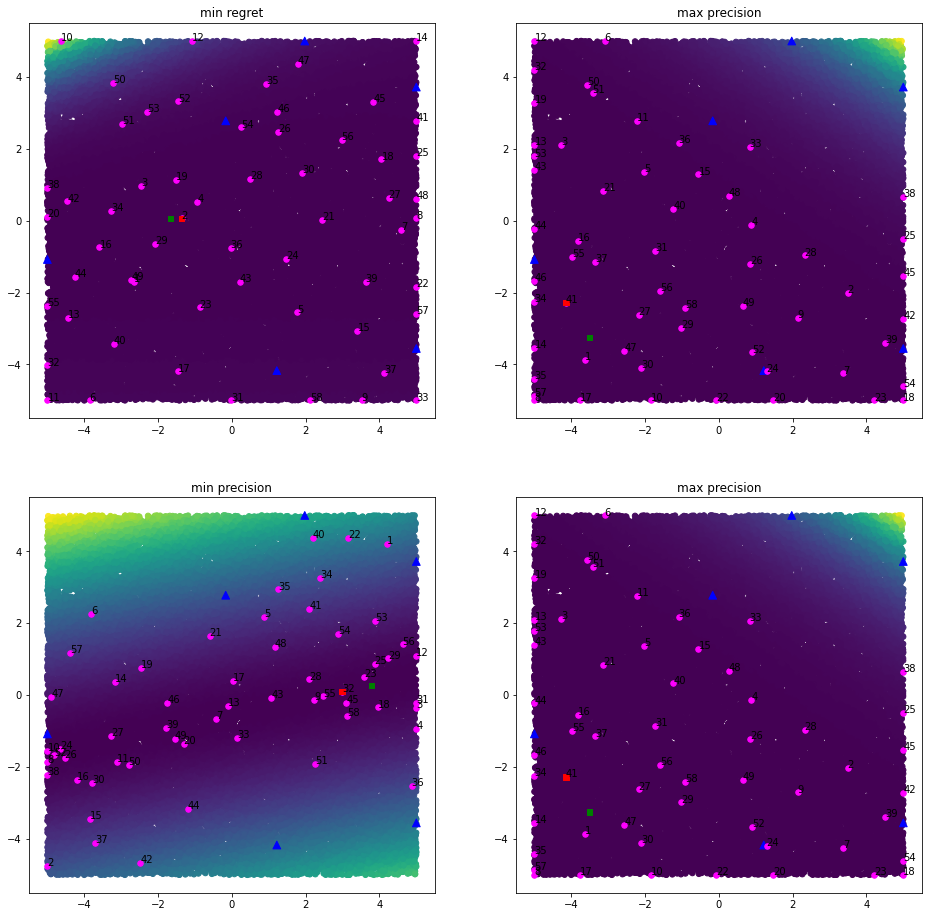

In [65]:
plt.rcParams["figure.figsize"] = (16, 16)
best_regret_52, worst_regret_52, best_precision_52, worst_precision_52 = best_and_worst(history_52)
plot_mult_performance(samples, (best_regret_52, worst_regret_52, best_precision_52, worst_precision_52), marker_size=30)

In [51]:
best_precision_52['precision'], best_precision_52['regret'], best_precision_52['f_s']

(144322867519904.7, array([16.69452388]), 1487394068)

In [52]:
best_regret_52['precision'], best_regret_52['regret'], best_precision_52['f_s']

(1.988779709226546e+16, array([0.21648234]), 1487394068)

In [62]:
good_52 = collect_by_criterion(history_52, not_obvious(3.08, 100))
len(good_52)

4

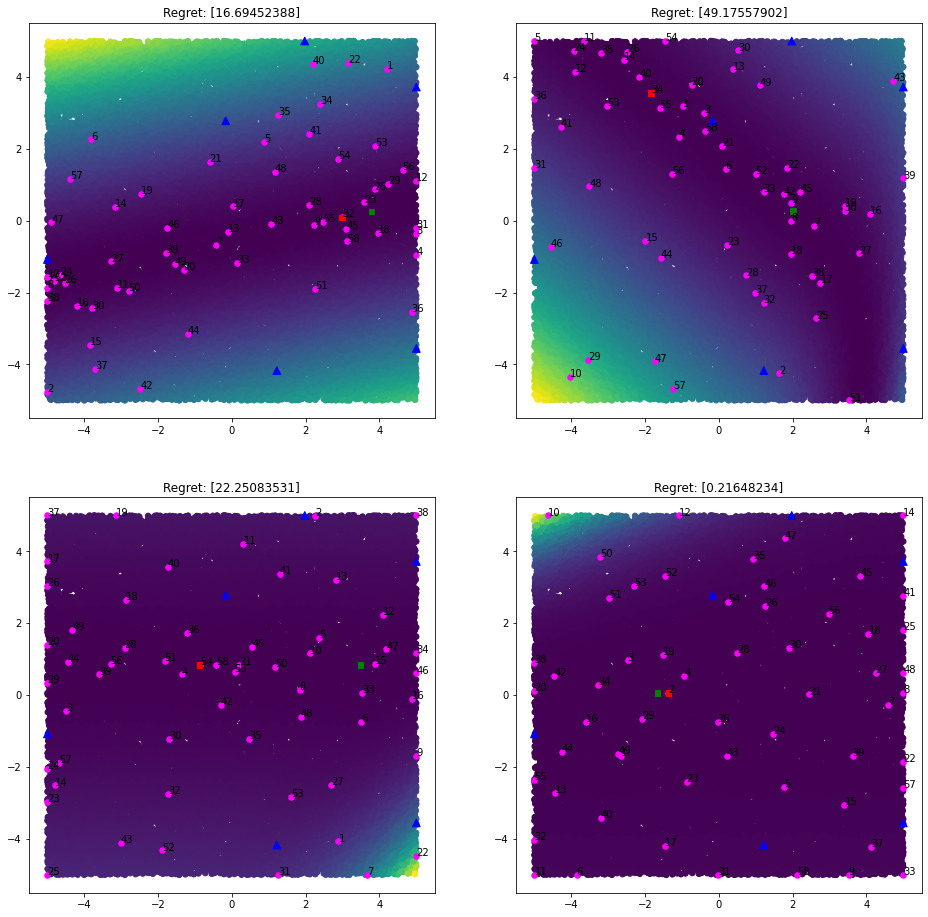

In [64]:
plt.rcParams["figure.figsize"] = (16, 16)
for h in good_52:
  h['title'] = 'Regret: ' + str(h['regret'])
plot_mult_performance(samples, good_52, marker_size=30)

In [70]:
df_52 = pd.DataFrame(additional_metrics(history_52)).drop(['title', 'bo'], axis=1)
df_52.to_csv('doe_52.csv')

### sigma = 5 / 3

In [16]:
doe53, es53 = cma_es_experiment(doe_size, individual0=individual0, sigma0=5/3, n_test=3)

(5_w,11)-aCMA-ES (mu_w=3.4,w_1=42%) in dimension 12 (seed=724589, Sat Nov  5 14:20:31 2022)
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelih

#### CMA-ES generated

In [17]:
precision_53, regret_53, history_53 = compute_all(np.random.RandomState(1), np.array(doe53), n=100, n_points=10000)

  0%|          | 0/100 [00:00<?, ?it/s]

Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likel

In [18]:
regret_53

3.3874584168919687e+19

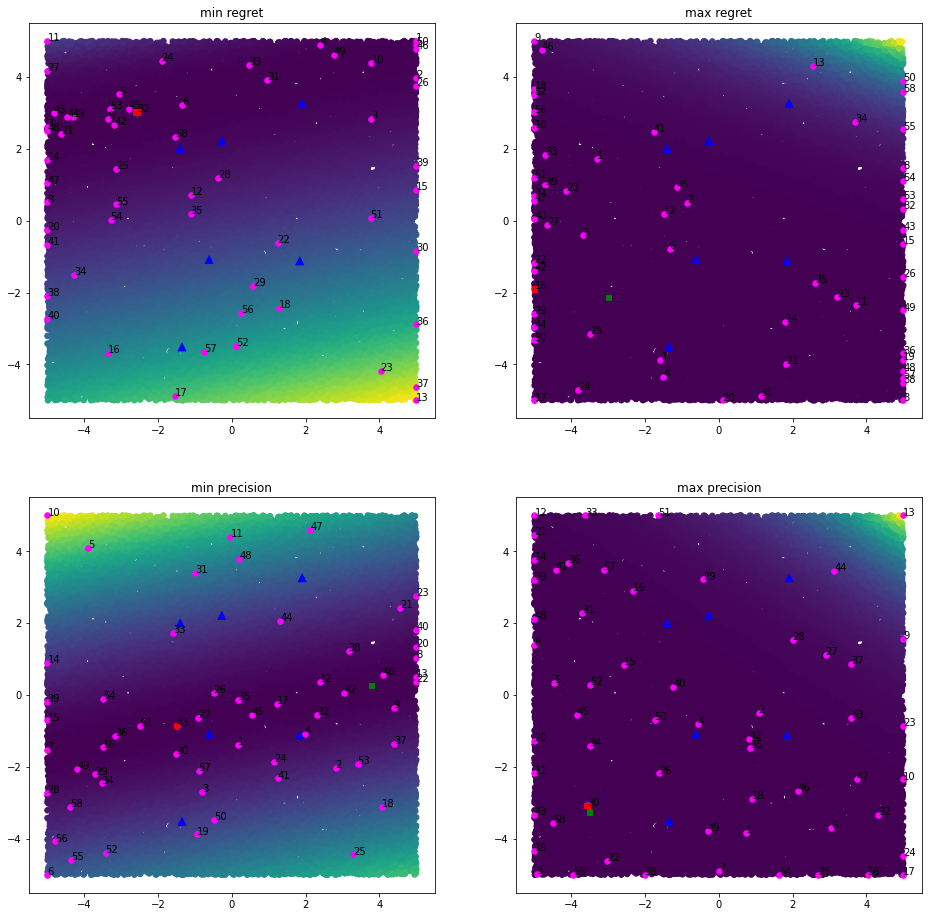

In [22]:
plt.rcParams["figure.figsize"] = (16, 16)
best_regret_53, worst_regret_53, best_precision_53, worst_precision_53 = best_and_worst(history_53)
plot_mult_performance(samples, (best_regret_53, worst_regret_53, best_precision_53, worst_precision_53), marker_size=30)

In [23]:
best_precision_53['precision'], best_precision_53['regret'], best_precision_53['f_s']

(146161857604687.22, array([55.06065711]), 1487394068)

In [24]:
best_regret_53['precision'], best_regret_53['regret'], best_precision_53['f_s']

(902821505745659.2, array([0.00329169]), 1487394068)

In [26]:
good_53 = collect_by_criterion(history_53, not_obvious(2.08, 100))
len(good_53)

4

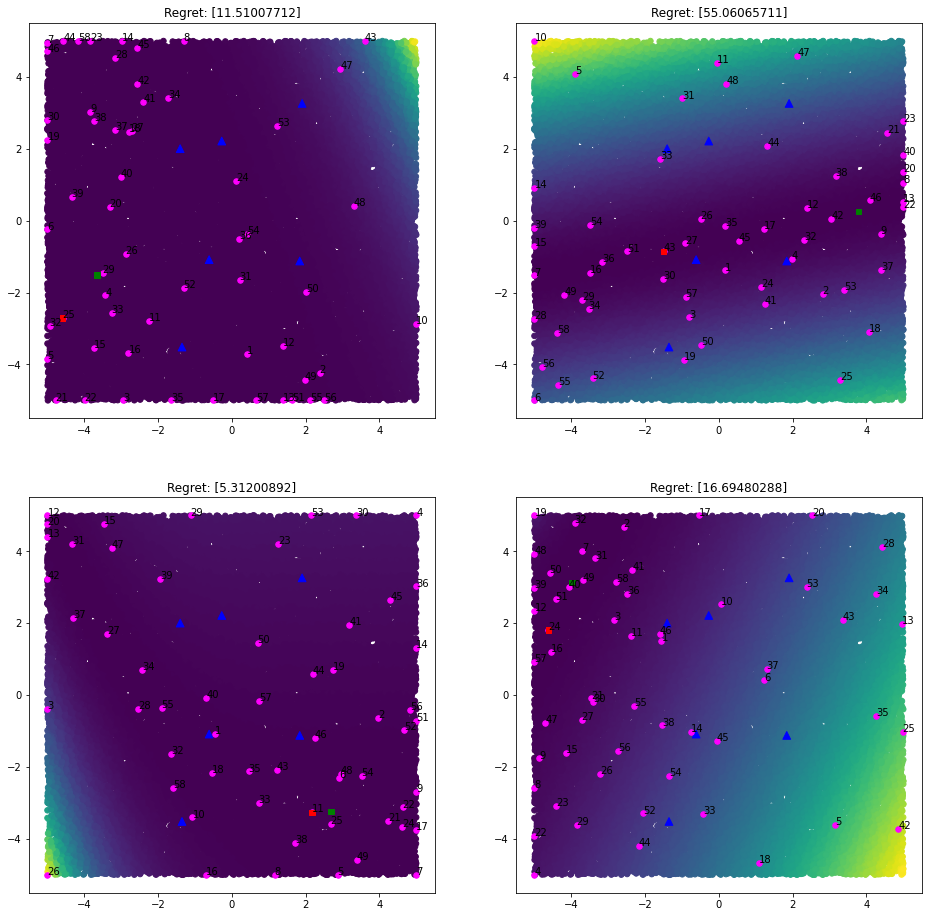

In [28]:
plt.rcParams["figure.figsize"] = (16, 16)
for h in good_53:
  h['title'] = 'Regret: ' + str(h['regret'])
plot_mult_performance(samples, good_53, marker_size=30)

In [29]:
df_53 = pd.DataFrame(additional_metrics(history_53)).drop(['title', 'bo'], axis=1)
df_53.to_csv('doe_53.csv')

In [30]:
doe53

[array([-0.27404018,  2.21628471]),
 array([-1.40131729,  2.00436069]),
 array([-1.3515667 , -3.51519472]),
 array([ 1.84029798, -1.1208768 ]),
 array([1.90427016, 3.26332232]),
 array([-0.61591423, -1.08397352])]